In [6]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from statsmodels.tsa.arima_model import ARIMA

def parser(x):
    return datetime.strptime(x, '%Y-%m')

data = pd.read_csv('co2-ppm-mauna-loa-19651980.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts = data

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #  Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()


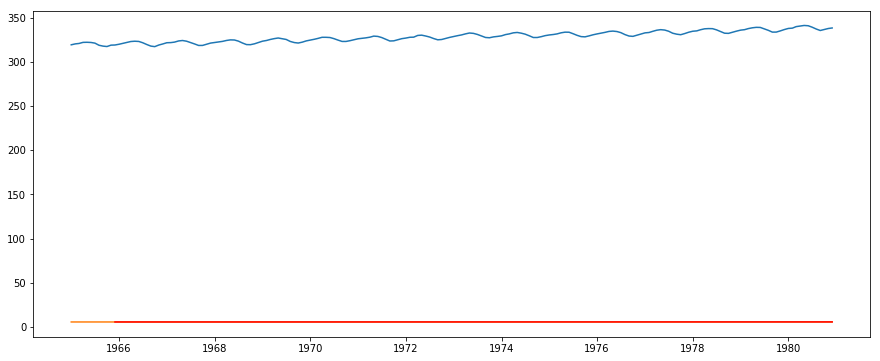

In [8]:
ts_log = np.log(ts)
plt.plot(ts)
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


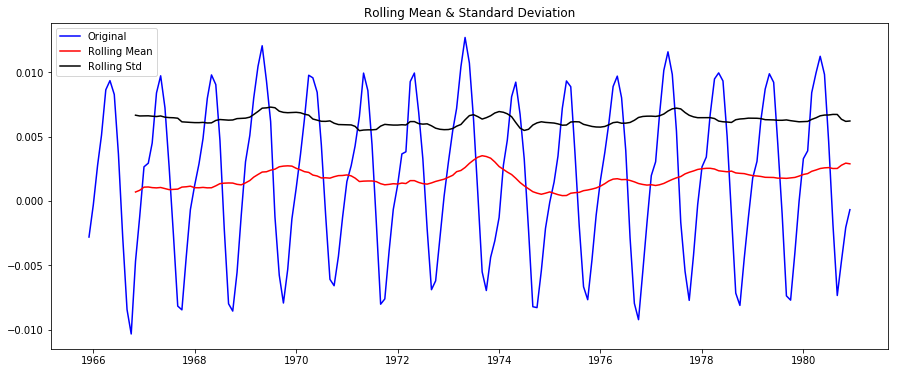

Results of Dickey-Fuller Test:
Test Statistic                  -2.913984
p-value                          0.043746
#Lags Used                      13.000000
Number of Observations Used    167.000000
Critical Value (5%)             -2.879008
Critical Value (1%)             -3.470126
Critical Value (10%)            -2.576083
dtype: float64


In [38]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


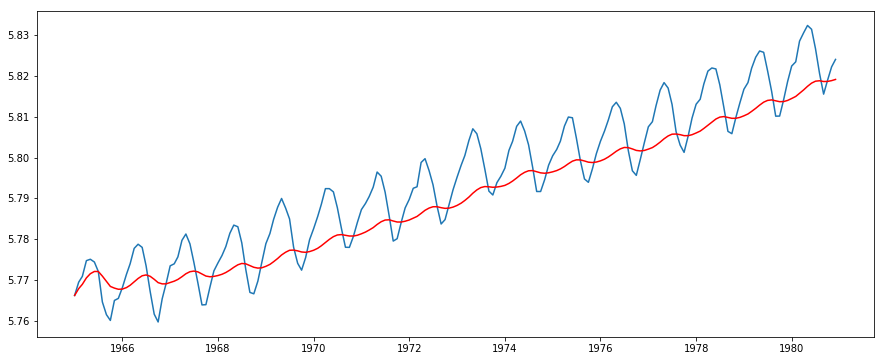

In [39]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


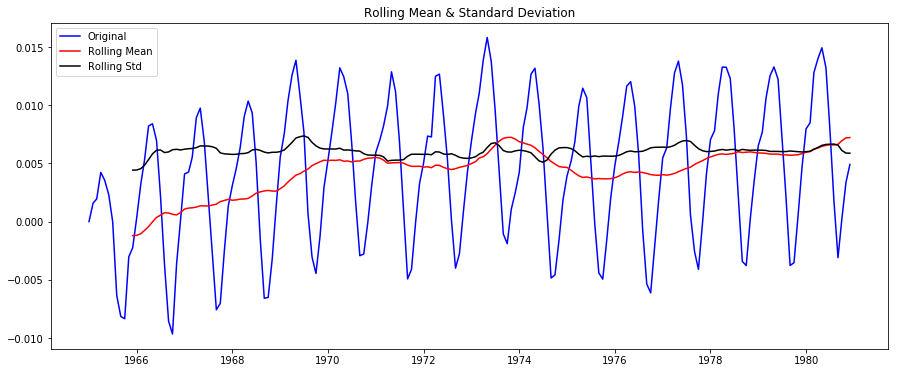

Results of Dickey-Fuller Test:
Test Statistic                  -2.788855
p-value                          0.059883
#Lags Used                      12.000000
Number of Observations Used    179.000000
Critical Value (5%)             -2.877826
Critical Value (1%)             -3.467420
Critical Value (10%)            -2.575452
dtype: float64


In [40]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

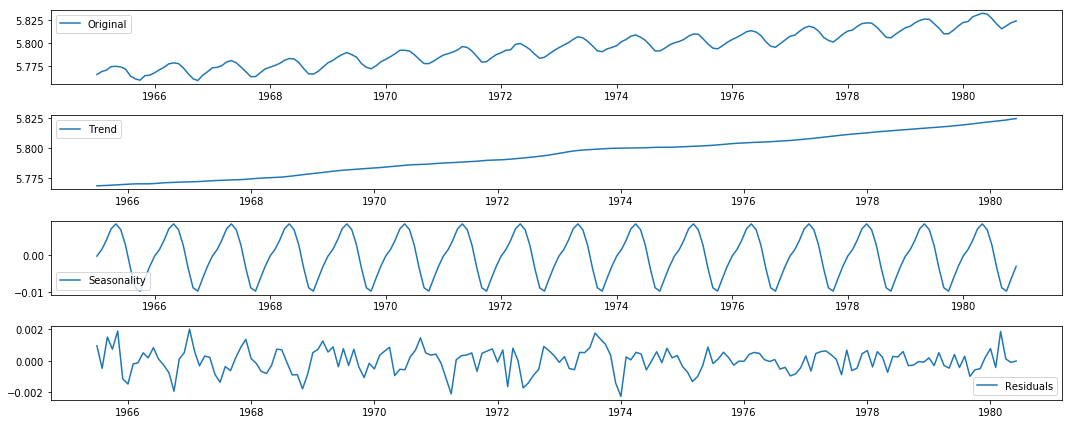

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


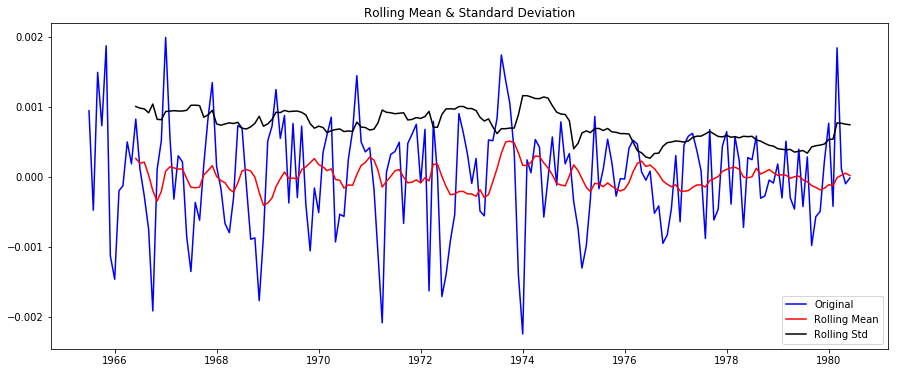

Results of Dickey-Fuller Test:
Test Statistic                -6.018404e+00
p-value                        1.514163e-07
#Lags Used                     1.000000e+01
Number of Observations Used    1.690000e+02
Critical Value (5%)           -2.878799e+00
Critical Value (1%)           -3.469648e+00
Critical Value (10%)          -2.575971e+00
dtype: float64


In [43]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [45]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_decompose, nlags=20)
lag_pacf = pacf(ts_log_decompose, nlags=20, method='ols')

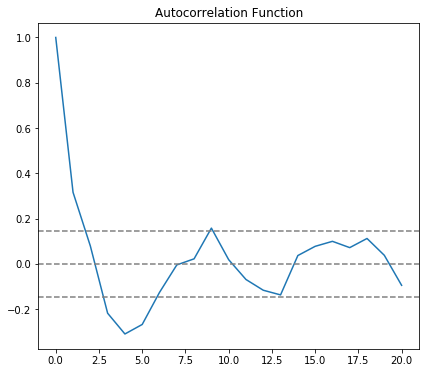

In [47]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

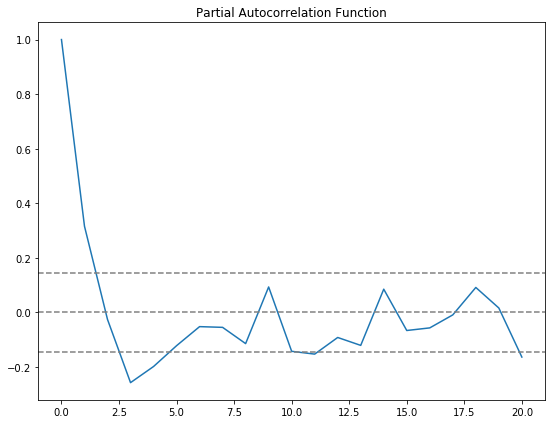

In [48]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

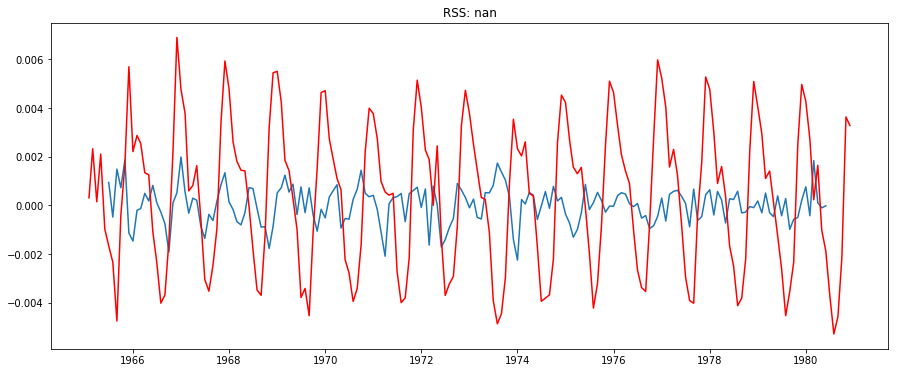

In [59]:
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_decompose)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_decompose)**2))

In [63]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value
=0)
predictions_ARIMA_log.head()

Month
1965-02-01    0.000310
1965-03-01    0.002327
1965-04-01    0.000145
1965-05-01    0.002106
1965-06-01   -0.000976
dtype: float64
Month
1965-02-01    0.000310
1965-03-01    0.002636
1965-04-01    0.002781
1965-05-01    0.004887
1965-06-01    0.003911
dtype: float64


Month
1965-01-01    5.766194
1965-02-01    5.766503
1965-03-01    5.768830
1965-04-01    5.768975
1965-05-01    5.771081
dtype: float64

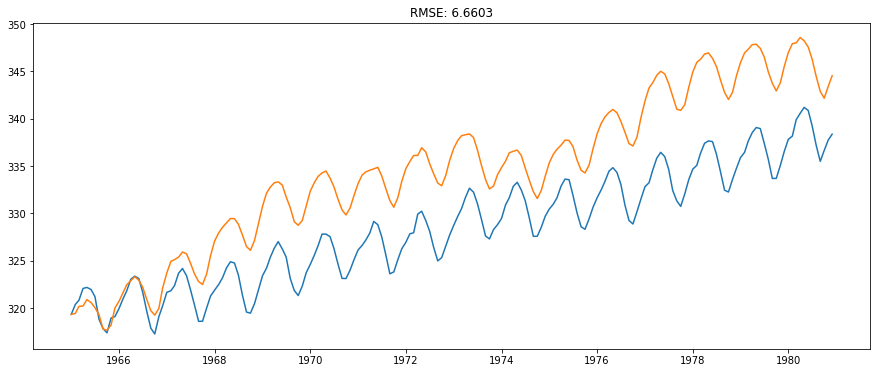

In [65]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))